# Shear Likelihood 2.1

### Preparing necessary libraries

In [1]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
from astropy import units
from numpy import random
plt.rcParams['font.family']=['gothambook','gotham','gotham-book','serif']

import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.utils import convert_units

### Creating mock data

In [2]:
np.random.seed(11)

cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

cluster_m     = 1.e15
logm = np.log(cluster_m)/np.log(10)
cluster_z     = 0.4
concentration = 4
ngals         = 10000
Delta         = 200
cluster_ra    = 20.0
cluster_dec   = 90.0

ideal_data   = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 0.8, zsrc_min = cluster_z + 0.1, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
ideal_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo,'chang13', zsrc_min = cluster_z + 0.1, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
noisy_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 'chang13', zsrc_min = cluster_z + 0.1, shapenoise=0.05, photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)

gc_ideal   = clmm.GalaxyCluster("CL_ideal", cluster_ra, cluster_dec, cluster_z, ideal_data)
gc_ideal_z = clmm.GalaxyCluster("CL_ideal_z", cluster_ra, cluster_dec, cluster_z, ideal_data_z)
gc_noisy_z = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, noisy_data_z)

# For some reason galaxy catalogs access information very deifferently from galaxy clusters

### Calculating observables

In [3]:
theta_ideal, gt_ideal, gx_ideal       = gc_ideal.compute_tangential_and_cross_components(geometry="flat")
theta_ideal_z, gt_ideal_z, gx_ideal_z = gc_ideal_z.compute_tangential_and_cross_components(geometry="flat")
theta_noisy_z, gt_noisy_z, gx_noisy_z = gc_noisy_z.compute_tangential_and_cross_components(geometry="flat")

# Convert from theta to radius
radius_ideal, radius_ideal_z, radius_noisy_z = [convert_units(gc.galcat['theta'], 'radians', 'Mpc', redshift=cluster_z, cosmo=cosmo) for gc in [gc_ideal, gc_ideal_z, gc_noisy_z]]

### Calculating lensing shear for each source

In [4]:
gt_lensing_ideal   = clmm.compute_reduced_tangential_shear(radius_ideal, cluster_m, concentration, gc_ideal.z, gc_ideal.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')
gt_lensing_ideal_z = clmm.compute_reduced_tangential_shear(radius_ideal_z, cluster_m, concentration, gc_ideal_z.z, gc_ideal_z.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')
gt_lensing_noisy_z = clmm.compute_reduced_tangential_shear(radius_noisy_z, cluster_m, concentration, gc_noisy_z.z, gc_noisy_z.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')

### Calculating $P_{KDE}(g^{L,i}_t)$

In [5]:
gt_lensing_ideal_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 0.01, 0.001)

for gt in gt_lensing_ideal:
    gt_lensing_ideal_kde.add_obs(gt)

gt_lensing_ideal_kde.prepare()



gt_lensing_ideal_z_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 0.01, 0.001)

for gt in gt_lensing_ideal_z:
    gt_lensing_ideal_z_kde.add_obs(gt)

gt_lensing_ideal_z_kde.prepare()



gt_lensing_noisy_z_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 0.01, 0.001)

for gt in gt_lensing_noisy_z:
    gt_lensing_noisy_z_kde.add_obs(gt)

gt_lensing_noisy_z_kde.prepare()


: 

: 

### Plotting $P_{KDE}(g^{L,i}_t)$

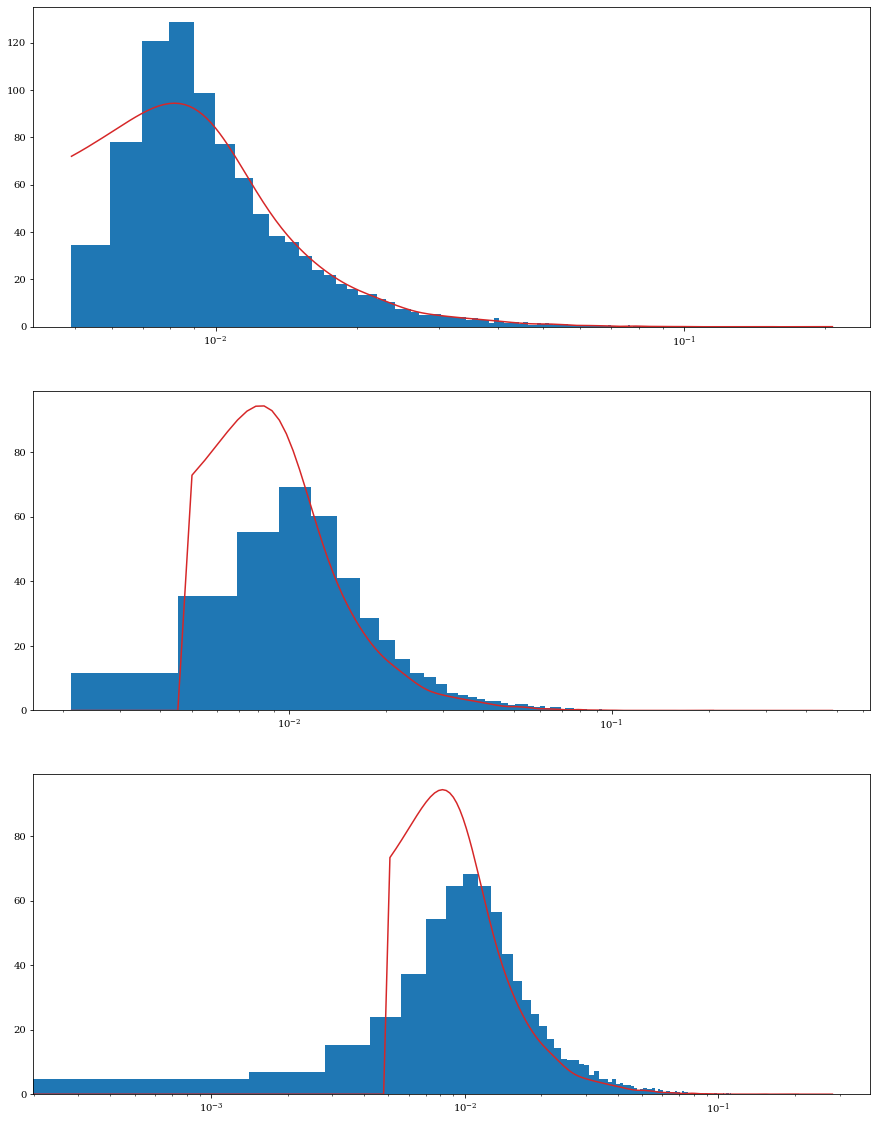

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15,20), facecolor="white")

for gt_list, kde, i in zip([gt_lensing_ideal, gt_lensing_ideal_z, gt_lensing_noisy_z], [gt_lensing_ideal_kde, gt_lensing_ideal_z_kde, gt_lensing_noisy_z_kde], range(3)):
    
    gt_min, gt_max = min(gt_list), max(gt_list)

    x = np.linspace(gt_min, gt_max, num=1000)
    y = [kde.eval_p(x_i) for x_i in x]
    
    ax[i].hist(gt_list, bins=200, density=True)
    ax[i].plot(x, y, color='tab:red')
    ax[i].set_xscale('log')
